### Let us first import the relevant libraries.

In [1]:
import os
import PIL
import numpy as np
import plotly.express as px

#SHAP
import shap

#PyTorch Libraries
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

#utils
from utils import visualize_cam, Normalize
#GradCAM
from gradcam import GradCAM, GradCAMpp
#Warnings
import warnings
warnings.filterwarnings('ignore')

### <code>TODO: Use the following figures from the images folder to create a GradCAM analysis.</code>
- Image 1: collies.jpg
- Image 2: snake.jpg
- Image 3: water-bird.jpg
- Image 4: multiple_dogs.jpg

In [2]:
# img_dir = '../images'
# img_name = 'cats1.JPG'
# img_path = os.path.join(img_dir, img_name)
# pil_img = PIL.Image.open(img_path)

In [2]:
image_dir = '../images'
img_name = ['collies.JPG', 'snake.JPEG', 'water-bird.JPEG', 'multiple_dogs.JPG']

In [3]:
print(os.listdir(image_dir))

['backprop.png', 'cats1.jpg', 'cats2.jpg', 'collies.JPG', 'GradCam.PNG', 'gradcam.webp', 'gradcam_sample.PNG', 'gradcam_sample.webp', 'multiple_dogs.jpg', 'pooling.png', 'pooling2.png', 'snake.JPEG', 'water-bird.JPEG']


In [4]:
img_path = [os.path.join(image_dir, i) for i in img_name]
pil_img= [PIL.Image.open(i) for i in img_path]

In [5]:
def normed(num):
    pil = pil_img[num]
    normalizer = Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
    torch_img = torch.from_numpy(np.asarray(pil)).permute(2, 0, 1).unsqueeze(0).float().div(255)
    torch_img = F.upsample(torch_img, size=(224, 224), mode= 'bilinear', align_corners=False)
    return normalizer(torch_img)

In [47]:
# normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# torch_img = torch.from_numpy(np.asarray(pil_img[0])).permute(2, 0, 1).unsqueeze(0).float().div(255)
# torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
# # normed_torch_img = normalizer(torch_img)

In [6]:
#normalized images
norm1 = normed(0)
norm2 = normed(1)
norm3 = normed(2)
norm4 = normed(3)

In [7]:
def torch_image(num):
    normalizer = Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
    torch_img = torch.from_numpy(np.asarray(pil_img[num])).permute(2, 0, 1).unsqueeze(0).float().div(255)
    return F.upsample(torch_img, size=(224, 224), mode= 'bilinear', align_corners=False)

#torch images
torch_img1 = torch_image(0)
torch_img2 = torch_image(1)
torch_img3 = torch_image(2)
torch_img4 = torch_image(3)

### <code>TODO: Use the pretrained ResNet101 for GradCAM</code>

In [8]:
''' 
    vgg         = models.vgg16(pretrained=True).eval()
    resnet      = models.resnet101(pretrained=True).eval()
    densenet    = models.densenet161(pretrained=True).eval()
    squeezenet  = models.squeezenet1_1(pretrained=True).eval()
'''

resnet101 = models.resnet101(pretrained=True).eval()

In [9]:
resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# modules = list(resnet101.children())[:-1] # delete the last fc layer.
# resnet = nn.Sequential(*modules)
# ### Now set requires_grad to false
# for param in resnet.parameters():
#     param.requires_grad = False

### <code>TODO: Change the CNN models into ResNet101</code>

In [10]:
cnn_models = [resnet101]
layer_name = ['layer4']
types = ['resnet']

def train_model(cnn_models, layer_name, types, input_size = (224, 224)):
    cam_dict = dict()
    for model, layer, type in zip(cnn_models, layer_name, types):
        model_dict = dict(type = type, arch = model, layer_name = layer, input_size = input_size)
        model_grad = GradCAM(model_dict, True)
        model_capp = GradCAMpp(model_dict, True)
        cam_dict[type] = [model_grad, model_capp]
        return cam_dict

def cam(normed_torch_img, torch_img):
    cam_dict = train_model(cnn_models, layer_name, types)
    images = []
    for gradcam, gradcam_pp in cam_dict.values():
        mask, _ = gradcam(normed_torch_img)
        heatmap, result = visualize_cam(mask, torch_img)
        mask_pp, _ = gradcam_pp(normed_torch_img)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    return make_grid(torch.cat(images, 0), nrow = 5)

In [11]:
image1=cam(norm1, torch_img1)
image2=cam(norm2, torch_img2)
image3=cam(norm3, torch_img3)
image4=cam(norm4, torch_img4)

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


In [12]:
output_dir = '../outputs'
os.makedirs(output_dir, exist_ok = True)

output_name = img_name
output_path = [os.path.join(output_dir, i) for i in output_name]

def grad_cam_image(images,x):
    save_image(images, output_path[x])
    return PIL.Image.open(output_path[x])

In [13]:
print(img_name)

['collies.JPG', 'snake.JPEG', 'water-bird.JPEG', 'multiple_dogs.JPG']


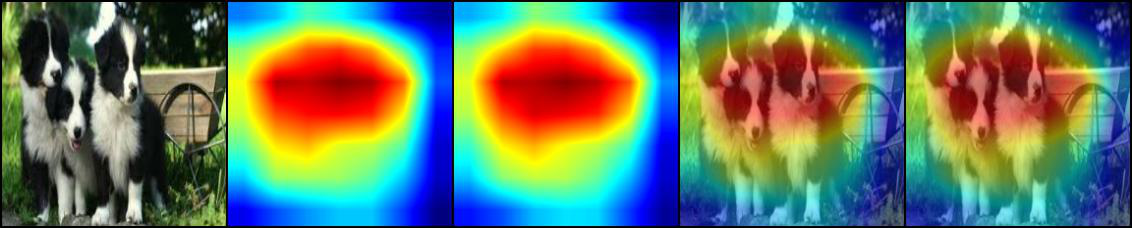

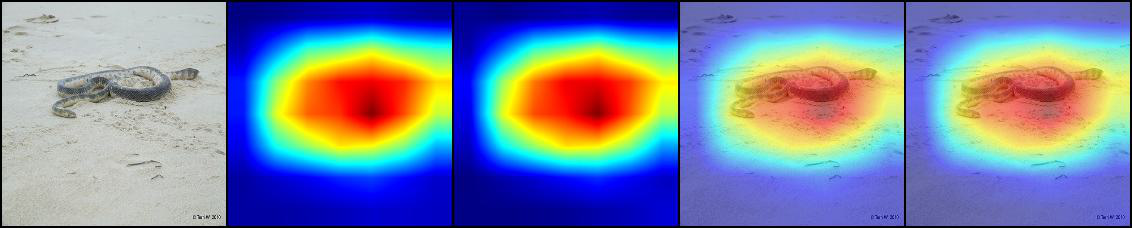

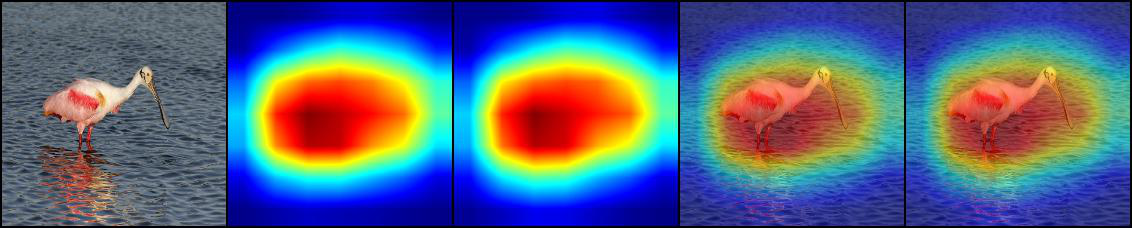

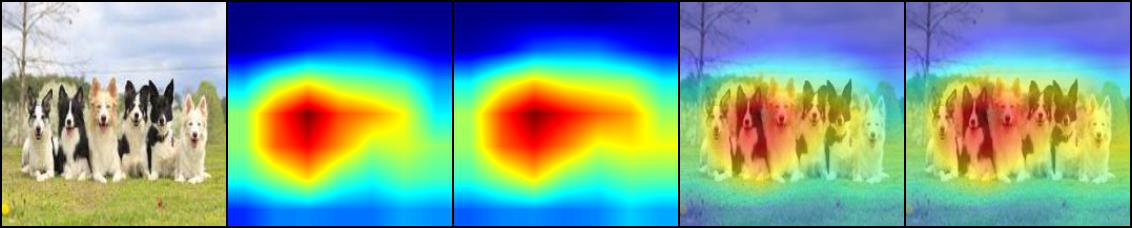

In [14]:
display(grad_cam_image(image1, 0))
display(grad_cam_image(image2, 1))
display(grad_cam_image(image3, 2))
display(grad_cam_image(image4, 3))

### <code>TODO: Use the DenseNet161 here using the similar images.</code>
### <code>TODO: Describe the results using GradCAM in DenseNet. What are the insights from the plots?</code>

In [21]:
# densenet    = models.densenet161(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\teeja/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [15]:
densenet    = models.densenet161(pretrained=True).eval()

In [16]:
cnn_models = [densenet]
layer_name = ['features_11', 'features_29', 'layer4', 'features_norm5']
types = ['alexnet', 'vgg', 'resnet', 'densenet', 'squeezenet']

def train_model(cnn_models, layer_name, types, input_size = (224, 224)):
    cam_dict = dict()
    for model, layer, type in zip(cnn_models, layer_name, types):
        model_dict = dict(type = type, arch = model, layer_name = layer, input_size = input_size)
        model_grad = GradCAM(model_dict, True)
        model_capp = GradCAMpp(model_dict, True)
        cam_dict[type] = [model_grad, model_capp]
        return cam_dict

def cam_dense(normed_torch_img, torch_img):
    cam_dict = train_model(cnn_models, layer_name, types)
    images = []
    for gradcam, gradcam_pp in cam_dict.values():
        mask, _ = gradcam(normed_torch_img)
        heatmap, result = visualize_cam(mask, torch_img)
        mask_pp, _ = gradcam_pp(normed_torch_img)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    return make_grid(torch.cat(images, 0), nrow = 5)

In [17]:
dense1=cam_dense(norm1, torch_img1)
dense2=cam_dense(norm2, torch_img2)
dense3=cam_dense(norm3, torch_img3)
dense4=cam_dense(norm4, torch_img4)

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


In [18]:
img_name_dense = ['collies_dense.JPG', 'snake_dense.JPEG', 'water-bird_dense.JPEG', 'multiple_dogs_dense.JPG']

output_dir = '../outputs'
os.makedirs(output_dir, exist_ok = True)

output_name = img_name_dense
output_path = [os.path.join(output_dir, i) for i in output_name]

def grad_cam_dense(images,x):
    save_image(images, output_path[x])
    return PIL.Image.open(output_path[x])

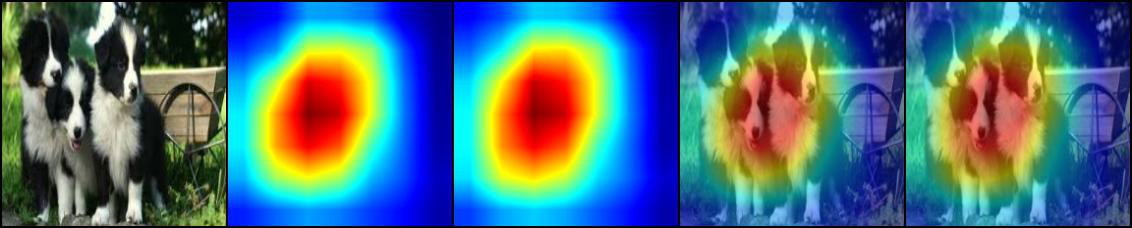

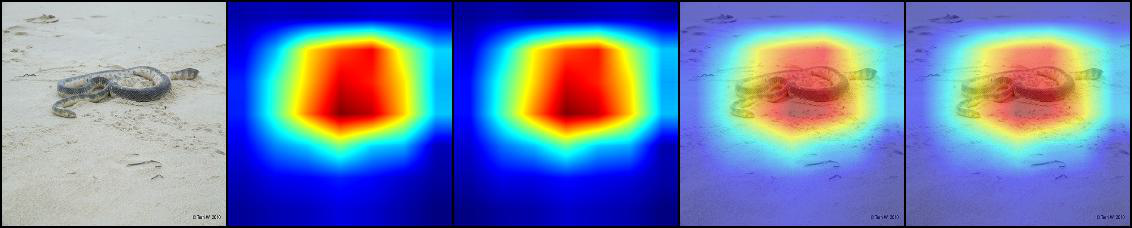

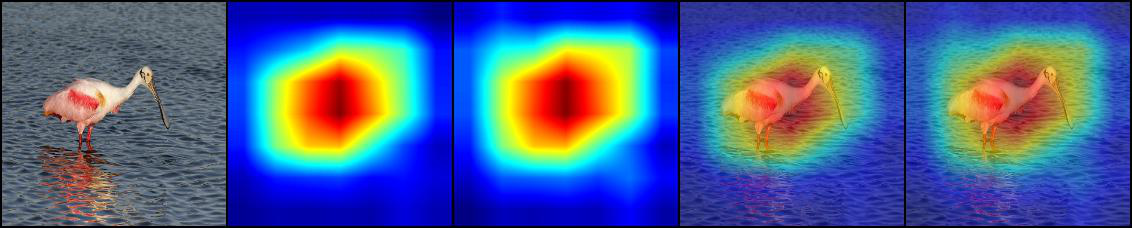

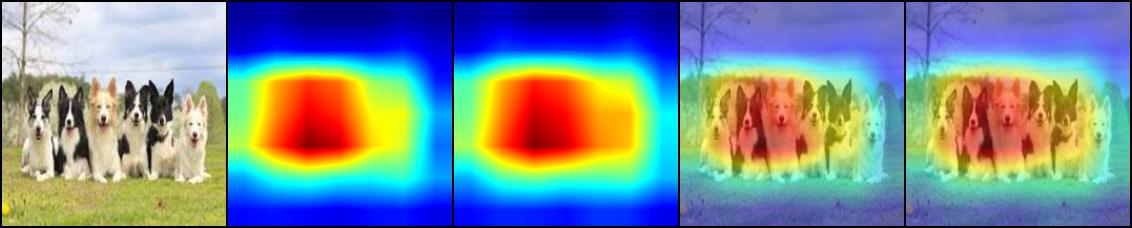

In [19]:
display(grad_cam_dense(dense1, 0))
display(grad_cam_dense(dense2, 1))
display(grad_cam_dense(dense3, 2))
display(grad_cam_dense(dense4, 3))